0. Preparation
Before any analyses we will prepare the dataset for the subsequent modelling.

1. Load the Auto dataset into R or Python.

In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

Auto=pd.read_csv("Auto.csv")

2. Drop all variables except the (potential) predictors ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'] and the target variable 'mpg'.

In [150]:
# keep the predictors and the outcome varibales 
predictors = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
target = 'mpg'
auto = Auto[predictors + [target]]

3. Split the dataset into a training set (80%) and a validation set (20%). It is probably a good idea to set a random seed and shuffle the dataset prior to this.

In [151]:
#split the dataset to training and validation sets(80%,20%)
train_data, val_data = train_test_split(auto, test_size=0.2, shuffle=True, random_state=100)

4. Replace missing values (coded as '?') in the both datasets with the mean of the given variable in the training set.

In [155]:

# check ? values
# print((train_data == '?').sum())
# print((val_data == '?').sum())
# print(train_data.isna().sum())
# print(val_data.isna().sum())

    
for col in predictors + [target]:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')

for col in predictors:
    mean_val = train_data[col].mean()
    train_data[col] = train_data[col].fillna(mean_val)
    val_data[col] = val_data[col].fillna(mean_val)



5. Standardize the predictors in the training set using z-score standardization.

In [74]:
# Standardize the predictors in the training set using z-score standardization.
for col in predictors:
    print(f'{col}: {np.mean(train_data[col]):.2f} ({np.std(train_data[col]):.2f})')

# z-score standardization
for col in predictors:
    train_data[col] = (train_data[col] - np.mean(train_data[col])) / np.std(train_data[col])

for col in predictors:
    print(f'{col} after: {np.mean(train_data[col]):.2f} ({np.std(train_data[col]):.2f})')

cylinders: 5.43 (1.71)
displacement: 191.34 (104.02)
horsepower: 104.22 (38.47)
weight: 2949.35 (847.54)
acceleration: 15.45 (2.72)
year: 76.00 (3.71)
cylinders after: 0.00 (1.00)
displacement after: -0.00 (1.00)
horsepower after: 0.00 (1.00)
weight after: 0.00 (1.00)
acceleration after: 0.00 (1.00)
year after: 0.00 (1.00)


6. Standardize the predictors in validation set based on the means and standard deviations from the training set.

In [75]:
for col in predictors:
    print(f'{col}: {np.mean(train_data[col]):.2f} ({np.std(train_data[col]):.2f})')

# z-score standardization
for col in predictors:
    val_data[col] = (train_data[col] - np.mean(train_data[col])) / np.std(train_data[col])

for col in predictors:
    print(f'{col} after: {np.mean(train_data[col]):.2f} ({np.std(train_data[col]):.2f})')

cylinders: 0.00 (1.00)
displacement: -0.00 (1.00)
horsepower: 0.00 (1.00)
weight: 0.00 (1.00)
acceleration: 0.00 (1.00)
year: 0.00 (1.00)
cylinders after: 0.00 (1.00)
displacement after: -0.00 (1.00)
horsepower after: 0.00 (1.00)
weight after: 0.00 (1.00)
acceleration after: 0.00 (1.00)
year after: 0.00 (1.00)


7. Reflection: Discuss briefly why it is a good idea (or even necessary?) to standardize the variables before fitting the LASSO models in assignment 2. Why do we mean-fill and standardize the validation set based on information from the training set?

It is a good idea and necessary to standardize the variables because this gives us the same scale/unit of the coefficients. Shrinkage penalizes  the coefficients directly regardless of the scales. If we do not standardize it, variables on larger scales will be penalized less than those on smaller scales. We use the information from the training set because we want to keep the model agnostic to the validation set during training

1. Manual variable selection
In this assignment all models should be unregularized linear regression models fitted to predict mpg as a function of various subset of predictors. When we refer to the best model we mean the one achieving the lowest mean absolute error (MAE) in the validation set, if not otherwise specified.

1. Find the optimal set of predictors of size [6, 5, 4, 3, 2, 1] based on model performance using backward stepwise selection. Print out each set.


In [158]:

current_predictors = predictors.copy()
all_models = {}  

# Loop until we reach 1 predictor
while len(current_predictors) > 1:
    best_model = {'mae': float('inf'), 'predictors': None}

    for predictor in current_predictors:
        reduced_predictors = [p for p in current_predictors if p != predictor]

        model = LinearRegression()
        model.fit(train_data[reduced_predictors], train_data[target])
        predictions = model.predict(val_data[reduced_predictors])
        mae = mean_absolute_error(val_data[target], predictions)

        if mae < best_model['mae']:
            best_model = {'mae': mae, 'predictors': reduced_predictors}

    current_predictors = best_model['predictors']
    all_models[len(current_predictors)] = current_predictors.copy()  

all_models[len(predictors)] = predictors.copy()

# Print results for each model size
print("Optimal sets of predictors using Backward Stepwise Selection based on MAE:")
for size in sorted(all_models.keys(), reverse=True):
    print(f"{size} predictors: {all_models[size]}")


Optimal sets of predictors using Backward Stepwise Selection based on MAE:
6 predictors: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
5 predictors: ['cylinders', 'horsepower', 'weight', 'acceleration', 'year']
4 predictors: ['horsepower', 'weight', 'acceleration', 'year']
3 predictors: ['weight', 'acceleration', 'year']
2 predictors: ['weight', 'year']
1 predictors: ['weight']


2. Based on the models you have already trained, plot both training and validation MAE as a function of the number of predictors.

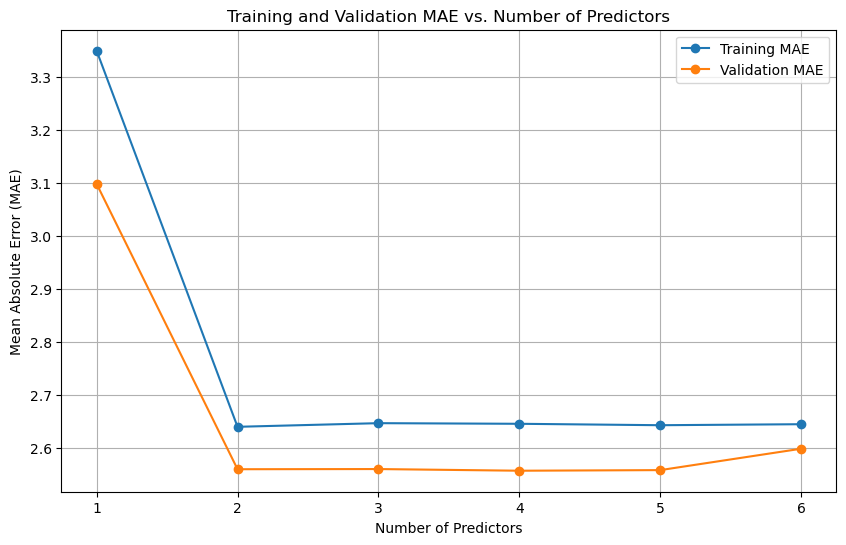

Optimal sets of predictors using Backward Stepwise Selection based on MAE:
5 predictors: ['cylinders', 'horsepower', 'weight', 'acceleration', 'year']
4 predictors: ['horsepower', 'weight', 'acceleration', 'year']
3 predictors: ['weight', 'acceleration', 'year']
2 predictors: ['weight', 'year']
1 predictors: ['weight']


In [172]:
# Initialize lists to store the MAE values
train_maes = []
val_maes = []
num_predictors = []

current_predictors = predictors.copy()
all_models = {}

# Loop until we reach 1 predictor
while len(current_predictors) > 1:
    best_model = {'mae': float('inf'), 'train_mae': float('inf'), 'val_mae': float('inf'), 'predictors': None}

    for predictor in current_predictors:
        reduced_predictors = [p for p in current_predictors if p != predictor]

        model = LinearRegression()
        model.fit(train_data[reduced_predictors], train_data[target])
        
        # Training and validation predictions
        train_predictions = model.predict(train_data[reduced_predictors])
        val_predictions = model.predict(val_data[reduced_predictors])
        
        # Calculate MAE for both training and validation
        train_mae = mean_absolute_error(train_data[target], train_predictions)
        val_mae = mean_absolute_error(val_data[target], val_predictions)

        # If this model is better, update the best_model
        if val_mae < best_model['val_mae']:
            best_model = {'mae': train_mae, 'train_mae': train_mae, 'val_mae': val_mae, 'predictors': reduced_predictors}

    # Store the training and validation MAEs for the current model
    current_predictors = best_model['predictors']
    train_maes.append(best_model['train_mae'])
    val_maes.append(best_model['val_mae'])
    num_predictors.append(len(current_predictors))

    all_models[len(current_predictors)] = current_predictors.copy()

# Final model with all predictors
train_maes.append(mean_absolute_error(train_data[target], LinearRegression().fit(train_data[predictors], train_data[target]).predict(train_data[predictors])))
val_maes.append(mean_absolute_error(val_data[target], LinearRegression().fit(train_data[predictors], train_data[target]).predict(val_data[predictors])))
num_predictors.append(len(predictors))

sorted_indices = sorted(range(len(num_predictors)), key=lambda k: num_predictors[k])
num_predictors_sorted = [num_predictors[i] for i in sorted_indices]
train_maes_sorted = [train_maes[i] for i in sorted_indices]
val_maes_sorted = [val_maes[i] for i in sorted_indices]

# Plotting the training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(num_predictors_sorted, train_maes_sorted, label="Training MAE", marker='o', linestyle='-')
plt.plot(num_predictors_sorted, val_maes_sorted, label="Validation MAE", marker='o', linestyle='-')
plt.xlabel("Number of Predictors")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Training and Validation MAE vs. Number of Predictors")
plt.legend()
plt.grid(True)
plt.show()

# Print results for each model size
print("Optimal sets of predictors using Backward Stepwise Selection based on MAE:")
for size in sorted(all_models.keys(), reverse=True):
    print(f"{size} predictors: {all_models[size]}")


3. Plot mpg predictions against actual mpg values for the validation set using the best model.

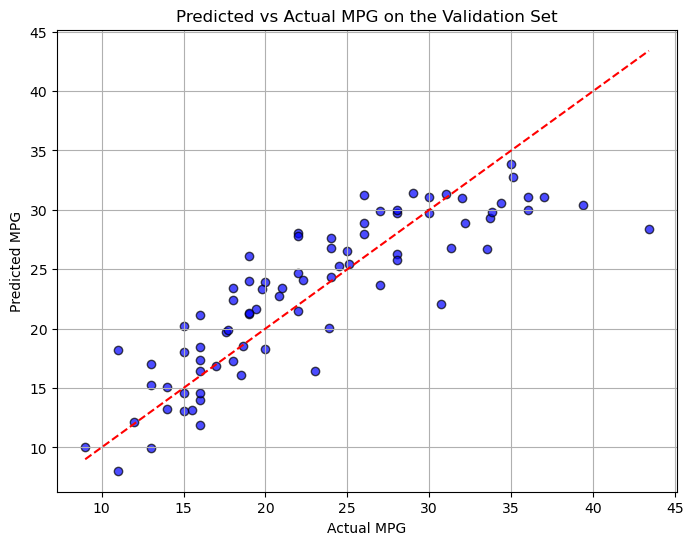

In [173]:

best_predictors = current_predictors  # The final set of predictors from the loop

# Train the final model using the best predictors
best_model = LinearRegression()
best_model.fit(train_data[best_predictors], train_data[target])

# Make predictions on the validation set
val_predictions = best_model.predict(val_data[best_predictors])

# Plotting the predicted vs actual mpg values
plt.figure(figsize=(8, 6))
plt.scatter(val_data[target], val_predictions, alpha=0.7, color='blue', edgecolors='black')
plt.plot([val_data[target].min(), val_data[target].max()], 
         [val_data[target].min(), val_data[target].max()], 
         color='red', linestyle='--')  # Line where predicted = actual
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Predicted vs Actual MPG on the Validation Set")
plt.grid(True)
plt.show()


4. Reflection: What is the best model based on training MAE? What about validation MAE? If they are different, reflect briefly on why. If not, could this happen? Why/why not?